<a href="https://colab.research.google.com/github/O-Kpy/Dacon/blob/main/Dacon_FIFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [78]:
train = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/FIFA_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/FIFA_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/submission.csv')
train.shape, test.shape

((8932, 12), (3828, 11))

In [79]:
data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])])

Text(0.5, 1.0, 'PF vs Value')

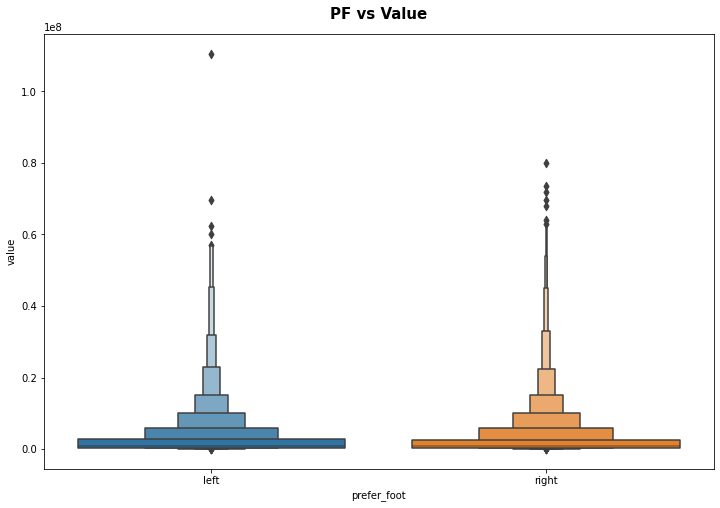

In [16]:
plt.figure(figsize=(12,8))
sns.boxenplot(x='prefer_foot', y='value', data=data)
plt.title('PF vs Value', fontsize=15, pad=15, fontweight='bold')

In [50]:
data

,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,is_european,age_bins
0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0,False,old
1,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,True,middle
2,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0,False,old
3,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0,True,old
4,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0,True,ealry
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,R. Takae,20,asia,2021,MF,right,1.0,48,63,2.0,NaN,False,youth
3824,L. Wahlstedt,18,europe,2018,GK,right,1.0,48,65,1.0,NaN,True,youth
3825,Y. Góez,18,south america,2021,MF,right,1.0,48,65,2.0,NaN,False,youth
3826,A. Kaltner,18,europe,2020,ST,right,1.0,47,61,2.0,NaN,True,youth


In [80]:
data['is_european'] = data['continent'].apply(lambda x: x=='europe')

Text(0.5, 1.0, 'PF vs Value')

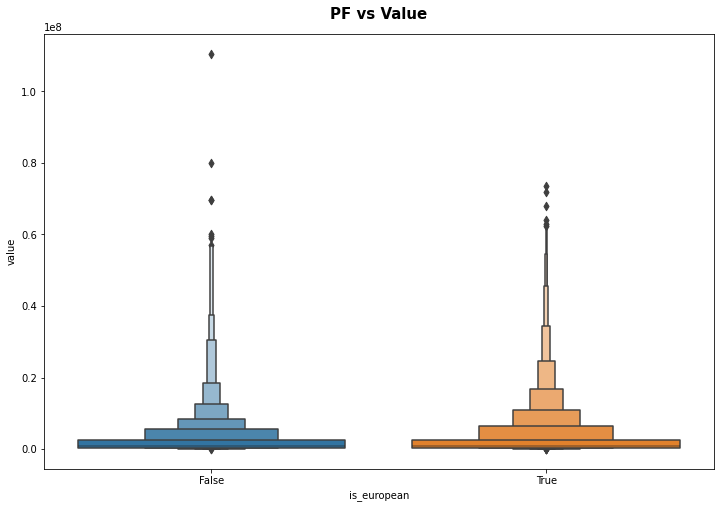

In [34]:
plt.figure(figsize=(12,8))
sns.boxenplot(x='is_european', y='value', data=data)
plt.title('PF vs Value', fontsize=15, pad=15, fontweight='bold')

In [81]:
bins = ['youth', 'young', 'ealry', 'middle', 'late', 'old']
data['age_bins'] = pd.qcut(data['age'], 6, labels=bins)

In [82]:
data['potential/overall'] = data['stat_potential']/data['stat_overall']

In [83]:
for i in data.select_dtypes(exclude='object').columns:
  if i in ['age_bins', 'value']:
    continue
  if data[i].skew() > 0.5:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i]+1))

In [58]:
data['contract_until'].value_counts()

2019            3309
2021            3293
2020            2923
2022            1099
2023             757
Jun 30, 2019     710
2018             482
Dec 31, 2018      98
May 31, 2019      33
2024              14
Jun 30, 2020      13
Jan 31, 2019      12
2025               7
Jan 1, 2019        3
May 31, 2020       2
2026               2
Jun 1, 2019        1
Jan 12, 2019       1
Dec 31, 2019       1
Name: contract_until, dtype: int64

In [84]:
data = pd.get_dummies(data, columns=['age_bins'])

In [85]:
x_train = data.loc[data.value.notnull()].drop(columns=['name', 'contract_until', 'value'])
y_train = data.loc[data.value.notnull()]['value']
x_test = data.loc[data.value.isnull()].drop(columns=['name', 'contract_until', 'value'])

In [90]:
pip install catboost

     |████████████████████████████████| 69.2MB 42kB/s 


In [91]:
pip install optuna

     |████████████████████████████████| 307kB 13.6MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 174kB 23.8MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
     |████████████████████████████████| 112kB 25.4MB/s 
     |████████████████████████████████| 143kB 26.2MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=81d1c07cd61d0f80a65dade14471efa6abfa08db376ee0d64117f1b1135e0f9e
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [92]:
import catboost
import lightgbm as lgbm
import optuna
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.metrics import mean_squared_error

In [103]:
kf = KFold(n_splits=7, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cat_features=x_train.select_dtypes(include='object')

preds_cat = np.zeros((x_test.shape[0]))


for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(learning_rate=0.22, loss_function='RMSE', cat_features=cat_features, n_estimators=3000, eval_metric='RMSE')
  model_cat.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], early_stopping_rounds=70, verbose=100)

  preds_cat = model_cat.predict(x_test)

0:	learn: 4725313.5182432	test: 5425810.4618750	best: 5425810.4618750 (0)	total: 4.96ms	remaining: 14.9s
100:	learn: 273415.0156839	test: 1111555.4450139	best: 1111555.4450139 (100)	total: 422ms	remaining: 12.1s
200:	learn: 202827.7961248	test: 1098233.0867637	best: 1098233.0867637 (200)	total: 858ms	remaining: 11.9s
300:	learn: 171769.1152177	test: 1092794.5814085	best: 1092794.5814085 (300)	total: 1.28s	remaining: 11.4s
400:	learn: 154806.3882858	test: 1090304.0756136	best: 1089974.3928614 (392)	total: 1.72s	remaining: 11.1s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 1089256.333
bestIteration = 429

Shrink model to first 430 iterations.
0:	learn: 4883883.5404508	test: 4654578.5187223	best: 4654578.5187223 (0)	total: 4.55ms	remaining: 13.7s
100:	learn: 286400.9820258	test: 707673.5057115	best: 707673.5057115 (100)	total: 402ms	remaining: 11.5s
200:	learn: 202445.4980283	test: 691648.4910982	best: 690745.7398490 (175)	total: 833ms	remaining: 11.6s
300:	learn: 171

In [105]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/submission.csv')
submit['value'] = preds_cat
submit = submit.set_index('id')
submit.to_csv('/content/drive/MyDrive/dataset/Dacon/연습/FIFA/submit2.csv')